In [1]:
!pip install --upgrade numexpr
!pip install imbalanced-learn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'End_dataframe.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Features and target
X = data[['Gender', 'Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]
y = data['VVR_Encoded']  # Assuming 'VVR_Encoded' is the target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
# Include the Gender column in SMOTE resampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the SVM model and parameter grid for Grid Search
svm = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [3, 4, 5],  
    'gamma': ['scale', 'auto']
}

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled.drop(columns='Gender'), y_train_resampled)

# Best model from Grid Search
best_svm = grid_search.best_estimator_

# Make predictions on the test set and training set
y_pred_test = best_svm.predict(X_test.drop(columns='Gender'))
y_pred_train = best_svm.predict(X_train_resampled.drop(columns='Gender'))

# Evaluate the model on the test set
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

print("\nTest Set Performance:")
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# Additional metrics for the test set

mcc_test = matthews_corrcoef(y_test, y_pred_test)

print(f"MCC (Test): {mcc_test:.2f}")

# Evaluate the model on the training set
print("\nTraining Set Performance:")
print("\nConfusion Matrix (Training Set):")
print(confusion_matrix(y_train_resampled, y_pred_train))
print("\nClassification Report (Training Set):")
print(classification_report(y_train_resampled, y_pred_train))

# Additional metrics for the training set
precision_train = precision_score(y_train_resampled, y_pred_train)
recall_train = recall_score(y_train_resampled, y_pred_train)
f1_train = f1_score(y_train_resampled, y_pred_train)
mcc_train = matthews_corrcoef(y_train_resampled, y_pred_train)

print(f"MCC (Train): {mcc_train:.2f}")

# Gender-wise analysis for test set
class_labels = {0: 'Low_VVR', 1: 'High_VVR'}
gender_labels = {1: 'Male', 2: 'Female'}

X_test['y_test'] = y_test  # Add true labels for easy grouping
X_test['y_pred'] = y_pred_test  # Add predictions

print("\nTest Set Performance by Gender:")
test_gender_groups = X_test.groupby('Gender')
for gender, group in test_gender_groups:
    gender_name = gender_labels.get(gender, gender)
    true_labels = group['y_test']
    predicted_labels = group['y_pred']
    print(f"\nGender: {gender_name}")
    print(confusion_matrix(true_labels, predicted_labels, labels=[0, 1]))
    print(classification_report(true_labels, predicted_labels, target_names=['Low_VVR', 'High_VVR']))
    print(f"MCC: {matthews_corrcoef(true_labels, predicted_labels):.2f}")

# Gender-wise analysis for training set
print("\nTraining Set Performance by Gender:")
X_train_resampled['y_train'] = y_train_resampled  # Add true labels
X_train_resampled['y_pred'] = y_pred_train  # Add predictions

train_gender_groups = X_train_resampled.groupby('Gender')
for gender, group in train_gender_groups:
    gender_name = gender_labels.get(gender, gender)
    true_labels = group['y_train']
    predicted_labels = group['y_pred']
    print(f"\nGender: {gender_name}")
    print(confusion_matrix(true_labels, predicted_labels, labels=[0, 1]))
    print(classification_report(true_labels, predicted_labels, target_names=['Low_VVR', 'High_VVR']))
    print(f"MCC: {matthews_corrcoef(true_labels, predicted_labels):.2f}")


Best Parameters from Grid Search:
{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

Test Set Performance:

Confusion Matrix (Test Set):
[[28 64]
 [11 26]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.72      0.30      0.43        92
           1       0.29      0.70      0.41        37

    accuracy                           0.42       129
   macro avg       0.50      0.50      0.42       129
weighted avg       0.59      0.42      0.42       129

MCC (Test): 0.01

Training Set Performance:

Confusion Matrix (Training Set):
[[133 231]
 [ 26 338]]

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.84      0.37      0.51       364
           1       0.59      0.93      0.72       364

    accuracy                           0.65       728
   macro avg       0.72      0.65      0.62       728
weighted avg       0.72      0.65      0.62       728

MCC (Tr

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
import pandas as pd

# Ensure only the original features are used for predictions
X_train_resampled_features = X_train_resampled.drop(columns=['Gender', 'y_pred', 'y_train'], errors='ignore')

# Evaluate performance on the training set
y_train_pred = best_svm.predict(X_train_resampled_features)  # Predictions on the training set
y_train_pred_prob = best_svm.predict_proba(X_train_resampled_features)  # Probabilities for each class

# Overall PR-AUC for High and Low VVR
precision_low, recall_low, _ = precision_recall_curve(1 - y_train_resampled, y_train_pred_prob[:, 0])
pr_auc_low = average_precision_score(1 - y_train_resampled, y_train_pred_prob[:, 0])

precision_high, recall_high, _ = precision_recall_curve(y_train_resampled, y_train_pred_prob[:, 1])
pr_auc_high = average_precision_score(y_train_resampled, y_train_pred_prob[:, 1])

# Compute the overall PR-AUC for the entire training set (considering positive class only)
overall_pr_auc = average_precision_score(y_train_resampled, y_train_pred_prob[:, 1])

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred)
class_report = classification_report(y_train_resampled, y_train_pred, target_names=['Low VVR', 'High VVR'])

# Gender-wise PR-AUC computation
gender_labels = {1: 'Male', 2: 'Female'}
pr_auc_gender = {}

for gender in [1, 2]:  # Male and Female
    gender_mask = X_train_resampled['Gender'] == gender
    y_gender = y_train_resampled[gender_mask]
    y_pred_prob_gender = y_train_pred_prob[gender_mask]
    
    # Compute PR-AUC for Low VVR
    precision_low_gender, recall_low_gender, _ = precision_recall_curve(1 - y_gender, y_pred_prob_gender[:, 0])
    pr_auc_gender[f'{gender_labels[gender]}_Low_VVR'] = average_precision_score(1 - y_gender, y_pred_prob_gender[:, 0])
    
    # Compute PR-AUC for High VVR
    precision_high_gender, recall_high_gender, _ = precision_recall_curve(y_gender, y_pred_prob_gender[:, 1])
    pr_auc_gender[f'{gender_labels[gender]}_High_VVR'] = average_precision_score(y_gender, y_pred_prob_gender[:, 1])

# Display results
print("Training Set Performance:")

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print("\nOverall PR-AUC Train:")
print(f"Low VVR PR-AUC: {pr_auc_low:.2f}")
print(f"High VVR PR-AUC: {pr_auc_high:.2f}")
print(f"Overall PR-AUC: {overall_pr_auc:.2f}")

print("\nPR-AUC Train by Gender:")
for key, value in pr_auc_gender.items():
    print(f"{key}: {value:.2f}")




Training Set Performance:

Confusion Matrix:
[[133 231]
 [ 26 338]]

Classification Report:
              precision    recall  f1-score   support

     Low VVR       0.84      0.37      0.51       364
    High VVR       0.59      0.93      0.72       364

    accuracy                           0.65       728
   macro avg       0.72      0.65      0.62       728
weighted avg       0.72      0.65      0.62       728


Overall PR-AUC Train:
Low VVR PR-AUC: 0.75
High VVR PR-AUC: 0.66
Overall PR-AUC: 0.66

PR-AUC Train by Gender:
Male_Low_VVR: 0.77
Male_High_VVR: 0.58
Female_Low_VVR: 0.73
Female_High_VVR: 0.70


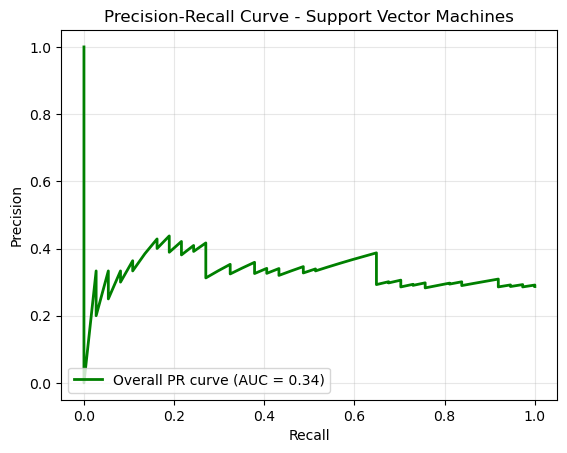

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Drop extra columns from X_test
X_test_features = X_test.drop(columns=['Gender', 'y_pred', 'y_test'], errors='ignore')  # Keep only original features

# Evaluate the best SVM model (from GridSearchCV)
y_pred_prob = best_svm.predict_proba(X_test_features)[:, 1]  # Probability of class 1

# Compute Precision-Recall curve and PR-AUC for the entire test set
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Gender-specific PR and AUC
gender_labels = {1: 'Male', 2: 'Female'}
pr_auc_gender = {}

plt.figure()

# Plot overall Precision-Recall curve
plt.plot(recall, precision, color='green', lw=2, label=f'Overall PR curve (AUC = {pr_auc:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Support Vector Machines')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.savefig('PR-AUC_SVM.pdf')

plt.show()



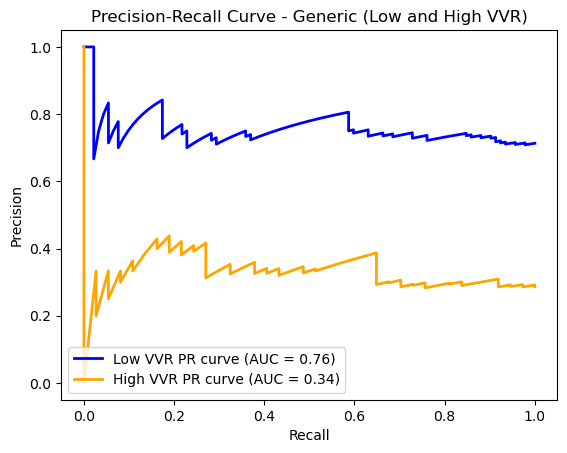

In [4]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# Generic PR-AUC figure for Low and High VVR
y_pred_prob_low = 1 - y_pred_prob  # Probability of Low VVR
y_pred_prob_high = y_pred_prob  # Probability of High VVR

precision_low, recall_low, _ = precision_recall_curve(1 - y_test, y_pred_prob_low)
pr_auc_low = average_precision_score(1 - y_test, y_pred_prob_low)

precision_high, recall_high, _ = precision_recall_curve(y_test, y_pred_prob_high)
pr_auc_high = average_precision_score(y_test, y_pred_prob_high)

# Plot PR curve
plt.figure()
plt.plot(recall_low, precision_low, color='blue', lw=2, label=f'Low VVR PR curve (AUC = {pr_auc_low:.2f})')
plt.plot(recall_high, precision_high, color='orange', lw=2, label=f'High VVR PR curve (AUC = {pr_auc_high:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Generic (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()


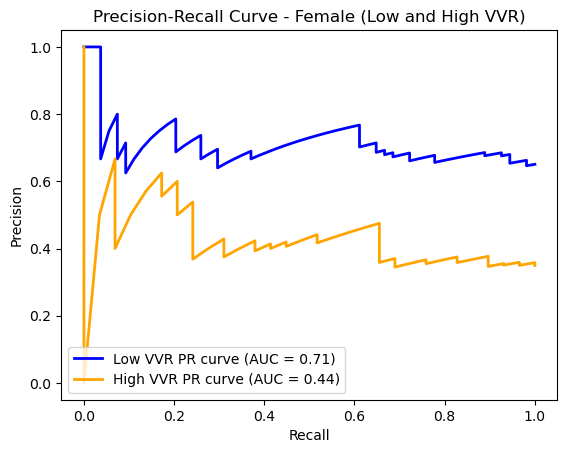

In [5]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# Female PR-AUC figure for Low and High VVR
female_mask = X_test['Gender'] == 2
y_test_female = y_test[female_mask]
y_pred_prob_female = y_pred_prob[female_mask]

y_pred_prob_low_female = 1 - y_pred_prob_female  # Probability of Low VVR
y_pred_prob_high_female = y_pred_prob_female  # Probability of High VVR

precision_low_female, recall_low_female, _ = precision_recall_curve(1 - y_test_female, y_pred_prob_low_female)
pr_auc_low_female = average_precision_score(1 - y_test_female, y_pred_prob_low_female)

precision_high_female, recall_high_female, _ = precision_recall_curve(y_test_female, y_pred_prob_high_female)
pr_auc_high_female = average_precision_score(y_test_female, y_pred_prob_high_female)

# Plot PR curve
plt.figure()
plt.plot(recall_low_female, precision_low_female, color='blue', lw=2, label=f'Low VVR PR curve (AUC = {pr_auc_low_female:.2f})')
plt.plot(recall_high_female, precision_high_female, color='orange', lw=2, label=f'High VVR PR curve (AUC = {pr_auc_high_female:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Female (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()


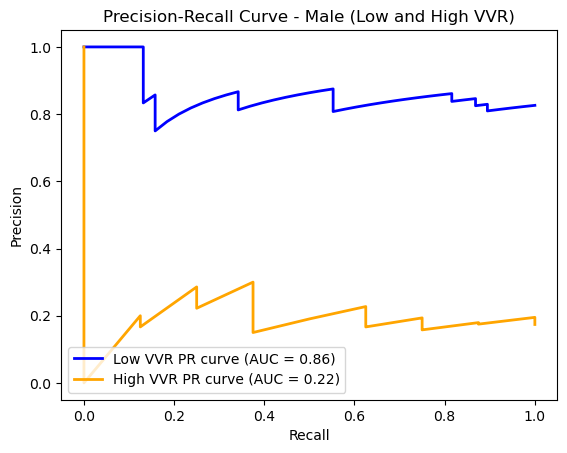

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# Male PR-AUC figure for Low and High VVR
male_mask = X_test['Gender'] == 1
y_test_male = y_test[male_mask]
y_pred_prob_male = y_pred_prob[male_mask]

y_pred_prob_low_male = 1 - y_pred_prob_male  # Probability of Low VVR
y_pred_prob_high_male = y_pred_prob_male  # Probability of High VVR

precision_low_male, recall_low_male, _ = precision_recall_curve(1 - y_test_male, y_pred_prob_low_male)
pr_auc_low_male = average_precision_score(1 - y_test_male, y_pred_prob_low_male)

precision_high_male, recall_high_male, _ = precision_recall_curve(y_test_male, y_pred_prob_high_male)
pr_auc_high_male = average_precision_score(y_test_male, y_pred_prob_high_male)

# Plot PR curve
plt.figure()
plt.plot(recall_low_male, precision_low_male, color='blue', lw=2, label=f'Low VVR PR curve (AUC = {pr_auc_low_male:.2f})')
plt.plot(recall_high_male, precision_high_male, color='orange', lw=2, label=f'High VVR PR curve (AUC = {pr_auc_high_male:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Male (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()


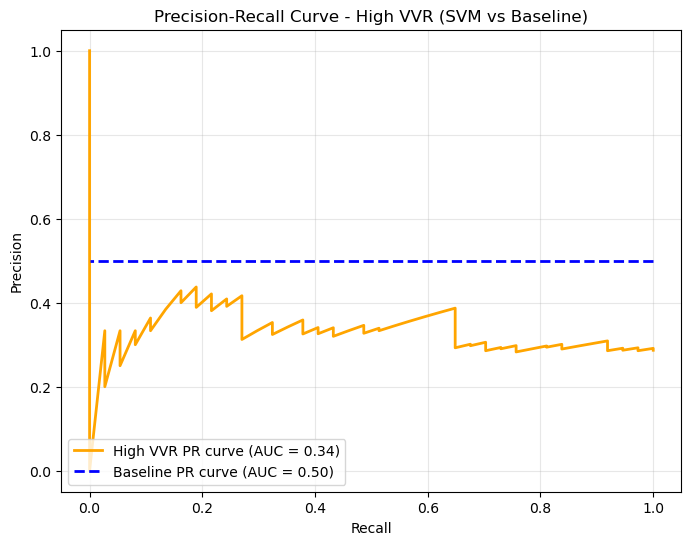

PR-AUC (High VVR): 0.34


In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generic PR-AUC figure for High VVR
y_pred_prob_high = y_pred_prob  # Probability of High VVR

# Compute Precision-Recall curve and PR-AUC for High VVR
precision_high, recall_high, _ = precision_recall_curve(y_test, y_pred_prob_high)
pr_auc_high = average_precision_score(y_test, y_pred_prob_high)

# Create a baseline PR curve with a constant precision of 0.50
baseline_precision = [0.50] * len(recall_high)

# Plot PR curve for High VVR and Baseline
plt.figure(figsize=(8, 6))
plt.plot(recall_high, precision_high, color='orange', lw=2, label=f'High VVR PR curve (AUC = {pr_auc_high:.2f})')
plt.plot(recall_high, baseline_precision, color='blue', lw=2, linestyle='--', label='Baseline PR curve (AUC = 0.50)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - High VVR (SVM vs Baseline)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.savefig('PR-AUC_SVM_VS_baseline.pdf')
plt.show()

# Print PR-AUC value for High VVR
print(f"PR-AUC (High VVR): {pr_auc_high:.2f}")
